In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

- Standardizing the data <br>
- Constructiong the covariance matrix <br>
- Obtaining eigen values and eigen vectors of covariance matrix <br>
- Sorting the eigenvalues in decreasing order to rank the eigenvectors 

In [3]:
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data',header = None)
df_wine.columns = ['Class label', 'Alcohol',
 'Malic acid', 'Ash',
 'Alcalinity of ash', 'Magnesium',
 'Total phenols', 'Flavanoids',
 'Nonflavanoid phenols',
 'Proanthocyanins',
 'Color intensity', 'Hue',
 'OD280/OD315 of diluted wines',
 'Proline']

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
X, y = df_wine.iloc[:,1:].values, df_wine.iloc[:,0].values
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3 , stratify = y, random_state = 0)

In [6]:
from sklearn.preprocessing import StandardScaler

In [7]:
std = StandardScaler()
X_train_std, X_test_std = std.fit_transform(X_train), std.fit_transform(X_test)

In [8]:
cov_mat = np.cov(X_train_std.T) #Calculating the covariance matrix of the standarddized feature matrix
eVal, eVec = np.linalg.eig(cov_mat)
print('\nEigenvalues \n%s' % eVal)


Eigenvalues 
[4.84274532 2.41602459 1.54845825 0.96120438 0.84166161 0.6620634
 0.51828472 0.34650377 0.3131368  0.10754642 0.21357215 0.15362835
 0.1808613 ]


In [9]:
cov_mat.shape

(13, 13)

Calculating Explained Variance

In [10]:
#Sincewe want to reduce the dimentionality of the dataset we only need to select the eigenvalues which contains most varinace
#hence we sort the e-val according to their magnitudes
#We first calculate total and explained variance
tot = sum(eVal)
var_exp = [i/tot for i in sorted(eVal, reverse = True)]
cum_var_exp = np.cumsum(var_exp)

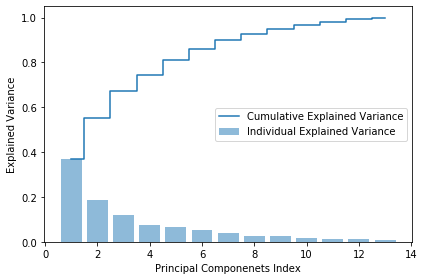

In [11]:
plt.bar(range(1,X_train_std.shape[1]+1),var_exp,alpha = 0.5, align = 'center', label = 'Individual Explained Variance')
plt.step(range(1,X_train_std.shape[1] + 1), cum_var_exp, where='mid', label = 'Cumulative Explained Variance')
plt.ylabel("Explained Variance")
plt.xlabel("Principal Componenets Index")
plt.tight_layout()
plt.legend(loc = 'best')
plt.show()

Feature Transformaton

- Select k eigenvetors, which correcponds to k largest eigenvalues, k is the dimentionality of the new fature space<br>
- Construct the projection matrix, W, from the 'top' k eigenvalues<br>
- Transform X from d dimentions to k dimentions using Wx = x'

In [12]:
ePairs = [(np.abs(eVal[i]), eVec[:,i]) for i in range(len(eVal))] 
ePairs.sort(key = lambda k:k[0], reverse = True) # sorting the tuples in decreasing order of e-vals

In [25]:
#We select two eVaecors which account for 60% variance in the dataset
w = np.hstack((ePairs[0][1][:, np.newaxis],
              ePairs[1][1][:, np.newaxis]))
w

array([[-0.13724218,  0.50303478],
       [ 0.24724326,  0.16487119],
       [-0.02545159,  0.24456476],
       [ 0.20694508, -0.11352904],
       [-0.15436582,  0.28974518],
       [-0.39376952,  0.05080104],
       [-0.41735106, -0.02287338],
       [ 0.30572896,  0.09048885],
       [-0.30668347,  0.00835233],
       [ 0.07554066,  0.54977581],
       [-0.32613263, -0.20716433],
       [-0.36861022, -0.24902536],
       [-0.29669651,  0.38022942]])

W is a 13*2 projection matrix from top 2 eigenValues

In [27]:
#Transforming the feature space
X_train_pca = X_train_std.dot(w)

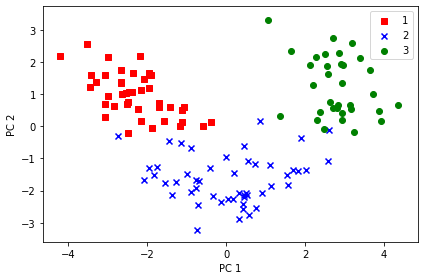

In [34]:
colors = ['r','b','g']
markers = ['s', 'x', 'o']
for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train == l, 0],X_train_pca[y_train == l, 1],c = c, label = l,marker = m)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc = 'best')
plt.tight_layout()
plt.show()

We can see that the dataset can easily be classified using a linear classifier

In [35]:
#Helper function to plot decision boundary
from matplotlib.colors import ListedColormap
def plotDecisionRegion(X, y, classifier, test_idx = None, resolution = 0.02):
    markers = ('s','x','o','^','v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    x1_min, x1_max = X[:, 0].min() - 1,X[:,0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1,X[:,1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min,x1_max,resolution),
                          np.arange(x2_min,x2_max, resolution))
    #xx1, xx2 are the coordinates of x and y respectively, we pair each value of the two corresponding matrices and get a grid
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1,xx2, Z, alpha = 0.3, cmap = cmap)
    plt.xlim(xx1.min(),xx1.max())
    plt.ylim(xx2.min(),xx2.max())
    
    for idx, c1 in enumerate(np.unique(y)):
        plt.scatter(x =X[y==c1,0],
                    y = X[y==c1,1],
                    alpha =0.8,
                    c = colors[idx],
                    marker = markers[idx],
                    label = c1, edgecolor='black')
    
    if test_idx:
        X_test, y_test = X[test_idx, :], y[test_idx]
        plt.scatter(X_test[:,0], X_test[:,1], c= '', edgecolors='black',
                    alpha=1.0, linewidths=1, marker='o', s=100, label='test set')

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

In [38]:
pca = PCA(n_components=2)
lr  = LogisticRegression(multi_class='ovr', 
                        random_state=1,
                        solver = 'lbfgs')
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.fit_transform(X_test_std)

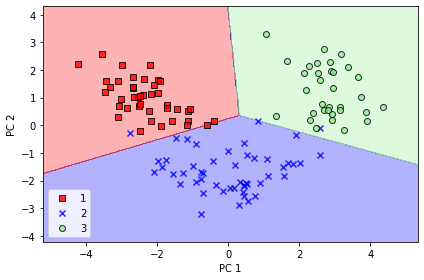

In [39]:
lr.fit(X_train_pca, y_train)
plotDecisionRegion(X_train_pca, y_train, classifier=lr)
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.legend(loc = "lower left")
plt.tight_layout()
plt.show()

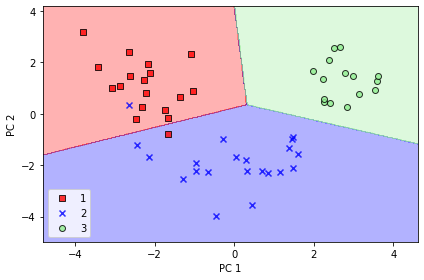

In [41]:
#Plotting decision region for test dataset 
plotDecisionRegion(-1*X_test_pca, y_test,classifier=lr)
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.legend(loc = "lower left")
plt.tight_layout()
plt.show()

In [42]:
pca = PCA(n_components=None)
X_train_pca =pca.fit_transform(X_train_std)

In [43]:
pca.explained_variance_ratio_

array([0.36951469, 0.18434927, 0.11815159, 0.07334252, 0.06422108,
       0.05051724, 0.03954654, 0.02643918, 0.02389319, 0.01629614,
       0.01380021, 0.01172226, 0.00820609])